# Telecom Churn - ML Group Case Study

# Objective: To reduce customer churn, need to predict which customers are at high risk of churn.

Analyse customer-level data of a leading telecom firm, build predictive models to identify customers at high risk of churn and identify the main indicators of churn.

Churn prediction is usually more critical (and non-trivial) for prepaid customers, and the term ‘churn’ should be defined carefully.  Pepaid is the most common model in India and southeast Asia, while postpaid is more common in Europe in North America.

## Definitions of Churn
Revenue-based churn: Customers who have not utilised any revenue-generating facilities such as mobile internet, outgoing calls, SMS etc. over a given period of time. One could also use aggregate metrics such as ‘customers who have generated less than INR 4 per month in total/average/median revenue’.

Usage-based churn: Customers who have not done any usage, either incoming or outgoing - in terms of calls, internet etc. over a period of time.

Use the usage-based definition to define churn.

## High-value Churn
In indian/SE market, approximately 80% of revenue comes from top 20% high-value customers. Churn reduction of high-value customers will reduce significant revenue leakage.
 
Define high-value customers based on a certain metric and predict churn only on high-value customers.

## Understanding the Business Objective and the Data
Dataset contains customer information for 4 consecutive months - June:6, July:7, August:8 and September:9. 

Business objective is to predict churn in the last (i.e. the ninth) month using the data (features) from first 3 months. To do this task well, understanding the typical customer behaviour during churn will be helpful.

## Understanding Customer Behaviour During Churn

Customers switch to another competitor over a period of time (especially applicable to high-value customers). We assume that there are three phases of customer lifecycle :

    ‘good’ phase: Customer is happy.
    ‘action’ phase: Customer experience deteriorates. Customer shows different behaviour than good’ months. Crucial to identify high-churn-risk customers in this phase since corrective actions can be taken at this point.
    ‘churn’ phase: Customer has churned. Define churn based on this phase. At the time of prediction (i.e. the action months), this data is not available for prediction. After tagging churn as 1/0 based on this phase, discard all data corresponding to this phase.

Over the four-month window, first 2 months are ‘good’ phase, 3rd month is ‘action’ phase, while 4th month is ‘churn’ phase.

## Data Preparation

The following data preparation steps are crucial for this problem:

1. Derive new features - Use business understanding to derive features that can be important indicators of churn.

2. Filter high-value customers - Predict churn only for high-value customers. High-value customers are those who have recharged with an amount more than or equal to X, where X is the 70th percentile of the average recharge amount in the first two months (the good phase).

After filtering the high-value customers, expect about 29.9k rows.

3. Tag churners and remove attributes of the churn phase - Tag the churned customers (churn=1, else 0) based on the fourth month as follows: Those who have not made any calls (either incoming or outgoing) AND have not used mobile internet even once in the churn phase. The attributes to tag churners are:

    total_ic_mou_9
    total_og_mou_9
    vol_2g_mb_9
    vol_3g_mb_9

After tagging churners, remove all attributes corresponding to the churn phase (all attributes having ‘ _9’, etc. in their names).

## Modelling

Build models to predict churn. The predictive model will serve two purposes:

    Predict whether a high-value customer will churn or not, in near future (i.e. churn phase). By knowing this, the company can take corrective actions.
    Identify important variables that are strong predictors of churn. These variables may also indicate why customers choose to switch to other networks.

We have a large number of attributes and thus we should try using a dimensionality reduction technique such as PCA and then build a predictive model. After PCA, use any classification model.
 
Since the rate of churn is typically low (about 5-10%, this is called class-imbalance) - try using techniques to handle class imbalance.

Take following suggestive steps to build the model:

    Preprocess data (convert columns to appropriate formats, handle missing values, etc.)

    Conduct appropriate EDA to extract useful insights (whether directly useful for business or for eventual modelling/feature engineering).

    Derive new features.

    Reduce the number of variables using PCA.

    Train a variety of models, tune model hyperparameters, etc. (handle class imbalance using appropriate techniques).

    Evaluate models using appropriate evaluation metrics. More important to identify churners than the non-churners accurately - choose an appropriate evaluation metric which reflects this business goal.

    Finally, choose a model based on some evaluation metric.

The above model will only be able to achieve one of the two goals - to predict customers who will churn. Above model cannot identify the important features for churn. That’s because PCA usually creates components which are not easy to interpret.

Therefore, build another model with the main objective of identifying important predictor attributes which help the business understand indicators of churn. A good choice to identify important variables is a logistic regression model or a model from the tree family. In case of logistic regression, make sure to handle multi-collinearity.

After identifying important predictors, display them visually - you can use plots, summary tables etc. - whatever you think best conveys the importance of features.

Finally, recommend strategies to manage customer churn based on your observations.

# Understand Data

## We see there are 226 columns and 99999 rows in the dataframe

In [137]:
# import functions from libraries that is used in the solution
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA
from sklearn.decomposition import IncrementalPCA
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

#Load the data from CSV file
telecom = pd.read_csv("telecom_churn_data.csv", encoding = "ISO-8859-1")
print(telecom.shape)

(99999, 226)


In [138]:
telecom.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99999 entries, 0 to 99998
Columns: 226 entries, mobile_number to sep_vbc_3g
dtypes: float64(179), int64(35), object(12)
memory usage: 172.4+ MB


# Data Preparation

In [140]:
# Find and treat categorical/date variables
cols = telecom.columns
num_cols = telecom._get_numeric_data().columns
num_cols
cat_columns = list(set(cols) - set(num_cols))
cat_columns

type( telecom['date_of_last_rech_7'])

pandas.core.series.Series

In [141]:
# We need days of the month and not the entire date . So extracting the day and updating the relevant columns
categorical_df = pd.DataFrame() 
for cat_list in cat_columns[:]:
    telecom[cat_list] = pd.to_datetime(telecom[cat_list],errors='coerce').dt.day 
    categorical_df[cat_list] = telecom[cat_list]

print((round(100*(categorical_df.isnull().sum()/len(categorical_df.index)),2)))
# Fill missing values with 0
categorical_df.fillna(0, inplace=True)
 

date_of_last_rech_7          1.77
last_date_of_month_6         0.00
date_of_last_rech_data_9    74.08
date_of_last_rech_data_7    74.43
date_of_last_rech_9          4.76
date_of_last_rech_data_6    74.85
date_of_last_rech_8          3.62
last_date_of_month_9         1.66
last_date_of_month_8         1.10
last_date_of_month_7         0.60
date_of_last_rech_data_8    73.66
date_of_last_rech_6          1.61
dtype: float64


In [142]:
# Drop irrelevant fields as these are of no releavnce or values and completely zero or null( for e.g loc_og_t2o_mou','std_og_t2o_mou','loc_ic_t2o_mou')

telecom = telecom.drop(['circle_id','mobile_number','loc_og_t2o_mou','std_og_t2o_mou','loc_ic_t2o_mou'], axis=1)
telecom = telecom.loc[:, ~telecom.columns.str.startswith('fb_user')]



In [143]:
# Check % of null values for all columns
print((round(100*(telecom.isnull().sum()/len(telecom.index)),2)))

last_date_of_month_6      0.00
last_date_of_month_7      0.60
last_date_of_month_8      1.10
last_date_of_month_9      1.66
arpu_6                    0.00
arpu_7                    0.00
arpu_8                    0.00
arpu_9                    0.00
onnet_mou_6               3.94
onnet_mou_7               3.86
onnet_mou_8               5.38
onnet_mou_9               7.75
offnet_mou_6              3.94
offnet_mou_7              3.86
offnet_mou_8              5.38
offnet_mou_9              7.75
roam_ic_mou_6             3.94
roam_ic_mou_7             3.86
roam_ic_mou_8             5.38
roam_ic_mou_9             7.75
roam_og_mou_6             3.94
roam_og_mou_7             3.86
roam_og_mou_8             5.38
roam_og_mou_9             7.75
loc_og_t2t_mou_6          3.94
loc_og_t2t_mou_7          3.86
loc_og_t2t_mou_8          5.38
loc_og_t2t_mou_9          7.75
loc_og_t2m_mou_6          3.94
loc_og_t2m_mou_7          3.86
                         ...  
arpu_2g_9                74.08
night_pc

In [144]:
# Calculate percentage of NaN values in DataFrame and only include columns that contain any NaN values
def get_percentage_missing(series):
    num = series.isnull().sum()
    den = len(series)
    return round(100*(num/den), 2)

df_with_any_null_values = telecom[telecom.columns[telecom.isnull().any()].tolist()]
get_percentage_missing(df_with_any_null_values)

last_date_of_month_7      0.60
last_date_of_month_8      1.10
last_date_of_month_9      1.66
onnet_mou_6               3.94
onnet_mou_7               3.86
onnet_mou_8               5.38
onnet_mou_9               7.75
offnet_mou_6              3.94
offnet_mou_7              3.86
offnet_mou_8              5.38
offnet_mou_9              7.75
roam_ic_mou_6             3.94
roam_ic_mou_7             3.86
roam_ic_mou_8             5.38
roam_ic_mou_9             7.75
roam_og_mou_6             3.94
roam_og_mou_7             3.86
roam_og_mou_8             5.38
roam_og_mou_9             7.75
loc_og_t2t_mou_6          3.94
loc_og_t2t_mou_7          3.86
loc_og_t2t_mou_8          5.38
loc_og_t2t_mou_9          7.75
loc_og_t2m_mou_6          3.94
loc_og_t2m_mou_7          3.86
loc_og_t2m_mou_8          5.38
loc_og_t2m_mou_9          7.75
loc_og_t2f_mou_6          3.94
loc_og_t2f_mou_7          3.86
loc_og_t2f_mou_8          5.38
                         ...  
max_rech_data_8          73.66
max_rech

In [145]:
# Checking NaN values again by only including columns that contain any NaN values
df_with_any_null_values = telecom[telecom.columns[telecom.isnull().any()].tolist()]
get_percentage_missing(df_with_any_null_values)

last_date_of_month_7      0.60
last_date_of_month_8      1.10
last_date_of_month_9      1.66
onnet_mou_6               3.94
onnet_mou_7               3.86
onnet_mou_8               5.38
onnet_mou_9               7.75
offnet_mou_6              3.94
offnet_mou_7              3.86
offnet_mou_8              5.38
offnet_mou_9              7.75
roam_ic_mou_6             3.94
roam_ic_mou_7             3.86
roam_ic_mou_8             5.38
roam_ic_mou_9             7.75
roam_og_mou_6             3.94
roam_og_mou_7             3.86
roam_og_mou_8             5.38
roam_og_mou_9             7.75
loc_og_t2t_mou_6          3.94
loc_og_t2t_mou_7          3.86
loc_og_t2t_mou_8          5.38
loc_og_t2t_mou_9          7.75
loc_og_t2m_mou_6          3.94
loc_og_t2m_mou_7          3.86
loc_og_t2m_mou_8          5.38
loc_og_t2m_mou_9          7.75
loc_og_t2f_mou_6          3.94
loc_og_t2f_mou_7          3.86
loc_og_t2f_mou_8          5.38
                         ...  
max_rech_data_8          73.66
max_rech

In [146]:
telecom.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99999 entries, 0 to 99998
Columns: 221 entries, last_date_of_month_6 to loc_ic_mou_change
dtypes: float64(187), int64(34)
memory usage: 168.6 MB


In [147]:
# Fill NaN values in important columns with either 0 or -1 as they are numerical columns with depedency
# on other referenced columns. Treating columns that have more than 70% missing values

# TODO: Why are we fillin up data for _9 fields here?
# TODO: Make a function here

telecom['total_rech_data_6'].fillna(0, inplace=True)
telecom['total_rech_data_7'].fillna(0, inplace=True)
telecom['total_rech_data_8'].fillna(0, inplace=True)
telecom['total_rech_data_9'].fillna(0, inplace=True)
telecom['av_rech_amt_data_6'].fillna(0, inplace=True)
telecom['av_rech_amt_data_7'].fillna(0, inplace=True)
telecom['av_rech_amt_data_8'].fillna(0, inplace=True)
telecom['av_rech_amt_data_9'].fillna(0, inplace=True)
telecom['max_rech_data_6'].fillna(0, inplace=True)
telecom['max_rech_data_7'].fillna(0, inplace=True)
telecom['max_rech_data_8'].fillna(0, inplace=True)
telecom['max_rech_data_9'].fillna(0, inplace=True)
telecom['count_rech_2g_6'].fillna(0, inplace=True)
telecom['count_rech_2g_7'].fillna(0, inplace=True)
telecom['count_rech_2g_8'].fillna(0, inplace=True)
telecom['count_rech_2g_9'].fillna(0, inplace=True)
telecom['count_rech_3g_6'].fillna(0, inplace=True)
telecom['count_rech_3g_7'].fillna(0, inplace=True)
telecom['count_rech_3g_8'].fillna(0, inplace=True)
telecom['count_rech_3g_9'].fillna(0, inplace=True)
telecom['arpu_3g_6'].fillna(0, inplace=True)
telecom['arpu_3g_7'].fillna(0, inplace=True)
telecom['arpu_3g_8'].fillna(0, inplace=True)
telecom['arpu_3g_9'].fillna(0, inplace=True)
telecom['arpu_2g_6'].fillna(0, inplace=True)
telecom['arpu_2g_7'].fillna(0, inplace=True)
telecom['arpu_2g_8'].fillna(0, inplace=True)
telecom['arpu_2g_9'].fillna(0, inplace=True)
telecom['night_pck_user_6'].fillna(-1, inplace=True)
telecom['night_pck_user_7'].fillna(-1, inplace=True)
telecom['night_pck_user_8'].fillna(-1, inplace=True)
telecom['night_pck_user_9'].fillna(-1, inplace=True)

## Most columns still have NaN values but the % has reduced significantly. Treat this later but for now lets check the NaN's in rows.

In [148]:
# Check the maximum number of NaN's in rows
telecom.isnull().sum(axis=1).max()

131

In [149]:
# Lets check how many rows have 50% of the data missing based on 210 columns
#telecom.apply(lambda x: x.count(), axis=1)
len(telecom[telecom.isnull().sum(axis=1) > 113].index)

1018

## 1018 rows are missing 50% of the data. Eliminate those rows which is 1% of the entire dataset.

In [150]:
# 1018 rows are missing 50% of the data. Eliminate those rows which is 1% of the entire dataset.
#original columns = 226, 50% = 113
telecom = telecom[telecom.isnull().sum(axis=1) <= 113]

In [152]:
# Checking NaN values again by only including columns that contain any NaN values
df_with_any_null_values = telecom[telecom.columns[telecom.isnull().any()].tolist()]
get_percentage_missing(df_with_any_null_values)

last_date_of_month_7         0.28
last_date_of_month_8         0.76
last_date_of_month_9         1.27
onnet_mou_6                  2.95
onnet_mou_7                  2.87
onnet_mou_8                  4.40
onnet_mou_9                  6.80
offnet_mou_6                 2.95
offnet_mou_7                 2.87
offnet_mou_8                 4.40
offnet_mou_9                 6.80
roam_ic_mou_6                2.95
roam_ic_mou_7                2.87
roam_ic_mou_8                4.40
roam_ic_mou_9                6.80
roam_og_mou_6                2.95
roam_og_mou_7                2.87
roam_og_mou_8                4.40
roam_og_mou_9                6.80
loc_og_t2t_mou_6             2.95
loc_og_t2t_mou_7             2.87
loc_og_t2t_mou_8             4.40
loc_og_t2t_mou_9             6.80
loc_og_t2m_mou_6             2.95
loc_og_t2m_mou_7             2.87
loc_og_t2m_mou_8             4.40
loc_og_t2m_mou_9             6.80
loc_og_t2f_mou_6             2.95
loc_og_t2f_mou_7             2.87
loc_og_t2f_mou

## All columns that have missing values are numeric. Imput the missing values with 0 for these columns

In [153]:
# Fill missing values with 0
telecom.fillna(0, inplace=True)

# Check for columns have missing values
df_with_any_null_values = telecom[telecom.columns[telecom.isnull().any()].tolist()]
get_percentage_missing(df_with_any_null_values)   

Series([], dtype: float64)

In [154]:
telecom.isnull().sum(axis=0).max()

0

In [155]:
telecom.isnull().sum(axis=1).max()

0

In [156]:
# Checking the entire dataset for missing values
print((round(100*(telecom.isnull().sum()/len(telecom.index)),2)))

last_date_of_month_6     0.0
last_date_of_month_7     0.0
last_date_of_month_8     0.0
last_date_of_month_9     0.0
arpu_6                   0.0
arpu_7                   0.0
arpu_8                   0.0
arpu_9                   0.0
onnet_mou_6              0.0
onnet_mou_7              0.0
onnet_mou_8              0.0
onnet_mou_9              0.0
offnet_mou_6             0.0
offnet_mou_7             0.0
offnet_mou_8             0.0
offnet_mou_9             0.0
roam_ic_mou_6            0.0
roam_ic_mou_7            0.0
roam_ic_mou_8            0.0
roam_ic_mou_9            0.0
roam_og_mou_6            0.0
roam_og_mou_7            0.0
roam_og_mou_8            0.0
roam_og_mou_9            0.0
loc_og_t2t_mou_6         0.0
loc_og_t2t_mou_7         0.0
loc_og_t2t_mou_8         0.0
loc_og_t2t_mou_9         0.0
loc_og_t2m_mou_6         0.0
loc_og_t2m_mou_7         0.0
                        ... 
arpu_2g_9                0.0
night_pck_user_6         0.0
night_pck_user_7         0.0
night_pck_user

#  Create derived features

In [157]:
telecom['onnet_mou_change'] = np.mean((telecom['onnet_mou_6'], telecom['onnet_mou_7']),axis=0) - telecom['onnet_mou_8']
telecom['loc_og_mou_change'] = np.mean((telecom['loc_og_mou_6'], telecom['loc_og_mou_7']),axis=0) - telecom['loc_og_mou_8']
telecom['std_og_t2t_mou_change'] = np.mean((telecom['std_og_t2t_mou_6'], telecom['std_og_t2t_mou_7']),axis=0) - telecom['std_og_t2t_mou_8']
telecom['loc_ic_mou_change'] = np.mean((telecom['loc_ic_mou_6'], telecom['loc_ic_mou_7']),axis=0) - telecom['loc_ic_mou_8']

# Check for Outliers in important Numerical columns to be used to find High Value Customers

In [62]:
telecom_final = telecom.copy()
num_telecom = telecom_final[['total_rech_amt_6','total_rech_amt_7']]

In [63]:
num_telecom.describe(percentiles=[.25,.5,.75,.90,.95,.99])

,total_rech_amt_6,total_rech_amt_7
count,98981.000000,98981.000000
mean,328.954941,325.043988
std,398.764991,409.029536
min,0.000000,0.000000
25%,110.000000,100.000000
50%,230.000000,220.000000
75%,440.000000,430.000000
90%,735.000000,735.000000
95%,996.000000,996.000000
99%,1687.000000,1731.200000


## In above distribution, numbers are gradually increasing. However, all the rech amount are below 20000 except the max which is an outlier and hence has to be treated

In [64]:
# Delete the outlier data
telecom_final = telecom_final.ix[~(telecom_final['total_rech_amt_6'] == 35190)]

C:\Users\eghopur\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  


In [65]:
# Check for outliers again
num_telecom = telecom_final[['total_rech_amt_6','total_rech_amt_7']]
num_telecom.describe(percentiles=[.25,.5,.75,.90,.95,.99])

,total_rech_amt_6,total_rech_amt_7
count,98980.000000,98980.000000
mean,328.602738,324.639766
std,383.062286,388.759046
min,0.000000,0.000000
25%,110.000000,100.000000
50%,230.000000,220.000000
75%,440.000000,430.000000
90%,734.100000,735.000000
95%,996.000000,996.000000
99%,1686.210000,1730.210000


# Find High Value Customers - Average amount recharged for the 6 and 7 month

In [66]:
# To find the High Value Customer (HVC)
# Define high-value customers as follows: Those who have recharged with an amount more than or equal to X, 
# where X is the 70th percentile of the average recharge amount in the first two months (the good phase).
telecom_final['tot_recharge_6_7'] = round((telecom_final['total_rech_amt_6'] + telecom_final['total_rech_amt_7'])/2)
telecom_final['tot_recharge_6_7']

0         307.0
1         229.0
2         242.0
3         270.0
4         273.0
5          60.0
6         360.0
7        1185.0
8         519.0
9         208.0
10          0.0
11        183.0
12        110.0
13        380.0
14         50.0
15        343.0
16        459.0
17        408.0
18         45.0
19        224.0
20        344.0
21        640.0
22        142.0
23        227.0
24        385.0
25        311.0
26         77.0
27         30.0
28         96.0
29         98.0
          ...  
99967      85.0
99968      88.0
99969      74.0
99970     392.0
99971     165.0
99972       0.0
99973     114.0
99974     465.0
99975      82.0
99976     244.0
99977      90.0
99979      55.0
99980     343.0
99981     312.0
99982      77.0
99983     195.0
99984     300.0
99985      48.0
99986     848.0
99987     186.0
99988     467.0
99989     145.0
99990      94.0
99991     160.0
99992     120.0
99994      85.0
99995     110.0
99996      60.0
99997     370.0
99998     355.0
Name: tot_recharge_6_7, 

In [78]:
telecom_final.sort_values("tot_recharge_6_7", axis=0, ascending=True, inplace=True)

In [79]:
# Find 70th percentile of average recharge amount in the first two months
percentile_70 = telecom_final.tot_recharge_6_7.quantile(0.7) # 70th percentile
percentile_70

370.0

## 70 percetile of average of recharge amount in 6 and 7 months is "370". Derive HVC based on this number

In [80]:
# Extracting the HVC customers using 70 percentile
telecom_hvc = pd.DataFrame(telecom_final.loc[(telecom_final.tot_recharge_6_7 >= percentile_70), :])
telecom_hvc.tail()

,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,last_date_of_month_6,last_date_of_month_7,last_date_of_month_8,last_date_of_month_9,arpu_6,arpu_7,arpu_8,...,sachet_3g_6,sachet_3g_7,sachet_3g_8,sachet_3g_9,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,sep_vbc_3g,tot_recharge_6_7
69968,0.0,0.0,0.0,30,31.0,31.0,30.0,7748.779,7386.464,6210.072,...,0,0,0,0,222,0.00,0.00,0.00,0.00,8735.0
98208,0.0,0.0,0.0,30,31.0,31.0,30.0,10877.945,6498.408,5880.292,...,0,0,0,0,1531,0.00,0.00,0.00,0.00,10265.0
67717,0.0,0.0,0.0,30,31.0,31.0,30.0,11261.349,16820.145,12533.285,...,0,0,0,0,374,0.00,0.00,0.00,0.00,16150.0
51314,0.0,0.0,0.0,30,31.0,31.0,30.0,15487.684,14624.089,16040.503,...,0,0,0,0,289,827.43,261.36,5.82,9.05,17282.0
33019,0.0,0.0,0.0,30,31.0,31.0,30.0,10955.066,8609.460,13505.996,...,0,0,0,0,2567,0.00,0.00,0.00,0.00,18750.0


In [81]:
telecom_hvc.shape

(29825, 221)

## We get 29825 high value customers which is as expected. 

# Tag churners and remove attributes of the churn phase

In [82]:
# Tag the churned customers (churn=1, else 0) based on the fourth month as follows:
# Those who have not made any calls (either incoming or outgoing) AND have not used 
# mobile internet even once in the churn phase.

telecom_hvc['tot_usage_9'] = telecom_hvc['total_ic_mou_9'] + telecom_hvc['total_og_mou_9'] + \
              telecom_hvc['vol_2g_mb_9'] + telecom_hvc['vol_3g_mb_9']
telecom_hvc['churn'] = (telecom_hvc['tot_usage_9'] == 0).astype(int)
telecom_hvc.tail(10)

,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,last_date_of_month_6,last_date_of_month_7,last_date_of_month_8,last_date_of_month_9,arpu_6,arpu_7,arpu_8,...,sachet_3g_8,sachet_3g_9,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,sep_vbc_3g,tot_recharge_6_7,tot_usage_9,churn
22370,0.0,0.0,0.0,30,31.0,31.0,30.0,9394.536,2227.569,0.000,...,0,0,185,0.00,0.00,0.00,0.00,6950.0,0.00,1
80414,0.0,0.0,0.0,30,31.0,31.0,30.0,8598.530,4122.626,8058.772,...,0,0,2498,0.00,0.00,0.00,0.00,7360.0,3423.65,0
10484,0.0,0.0,0.0,30,31.0,31.0,30.0,5220.209,5451.082,8989.682,...,0,0,252,0.00,0.00,0.00,0.00,7644.0,291.72,0
78970,0.0,0.0,0.0,30,31.0,31.0,30.0,4513.948,6876.324,5228.826,...,0,0,1136,16.65,165.40,205.81,0.00,7728.0,0.00,1
61944,0.0,0.0,0.0,30,31.0,31.0,30.0,26.240,13224.119,2026.468,...,0,0,306,21.76,706.89,0.00,0.00,8507.0,0.00,1
69968,0.0,0.0,0.0,30,31.0,31.0,30.0,7748.779,7386.464,6210.072,...,0,0,222,0.00,0.00,0.00,0.00,8735.0,1565.10,0
98208,0.0,0.0,0.0,30,31.0,31.0,30.0,10877.945,6498.408,5880.292,...,0,0,1531,0.00,0.00,0.00,0.00,10265.0,891.72,0
67717,0.0,0.0,0.0,30,31.0,31.0,30.0,11261.349,16820.145,12533.285,...,0,0,374,0.00,0.00,0.00,0.00,16150.0,1944.94,0
51314,0.0,0.0,0.0,30,31.0,31.0,30.0,15487.684,14624.089,16040.503,...,0,0,289,827.43,261.36,5.82,9.05,17282.0,2983.71,0
33019,0.0,0.0,0.0,30,31.0,31.0,30.0,10955.066,8609.460,13505.996,...,0,0,2567,0.00,0.00,0.00,0.00,18750.0,85.92,0


In [83]:
print(telecom_hvc.shape)

(29825, 223)


# Remove all the attributes corresponding to the churn phase

In [84]:
# After tagging churners, remove all the attributes corresponding to the churn phase 
# (all attributes having ‘ _9’, etc. in their names).
telecom_hvc = telecom_hvc.loc[:, ~telecom_hvc.columns.str.endswith('_9')]

In [85]:
print(telecom_hvc.shape)

(29825, 169)


# Feature Standardisation

In [86]:
#Removing the categorical features from the data set before normalization

loc_og_t2o_mou          0.0
std_og_t2o_mou          0.0
loc_ic_t2o_mou          0.0
last_date_of_month_6    0.0
last_date_of_month_7    0.0
last_date_of_month_8    0.0
arpu_6                  0.0
arpu_7                  0.0
arpu_8                  0.0
onnet_mou_6             0.0
onnet_mou_7             0.0
onnet_mou_8             0.0
offnet_mou_6            0.0
offnet_mou_7            0.0
offnet_mou_8            0.0
roam_ic_mou_6           0.0
roam_ic_mou_7           0.0
roam_ic_mou_8           0.0
roam_og_mou_6           0.0
roam_og_mou_7           0.0
roam_og_mou_8           0.0
loc_og_t2t_mou_6        0.0
loc_og_t2t_mou_7        0.0
loc_og_t2t_mou_8        0.0
loc_og_t2m_mou_6        0.0
loc_og_t2m_mou_7        0.0
loc_og_t2m_mou_8        0.0
loc_og_t2f_mou_6        0.0
loc_og_t2f_mou_7        0.0
loc_og_t2f_mou_8        0.0
                       ... 
vol_3g_mb_7             0.0
vol_3g_mb_8             0.0
arpu_3g_6               0.0
arpu_3g_7               0.0
arpu_3g_8           

In [88]:
normalized_df=(telecom_hvc-telecom_hvc.mean())/telecom_hvc.std()
#normalized_df.head()

print((round(100*(normalized_df.isnull().sum()/len(normalized_df.index)),2)))

loc_og_t2o_mou          100.0
std_og_t2o_mou          100.0
loc_ic_t2o_mou          100.0
last_date_of_month_6    100.0
last_date_of_month_7      0.0
last_date_of_month_8      0.0
arpu_6                    0.0
arpu_7                    0.0
arpu_8                    0.0
onnet_mou_6               0.0
onnet_mou_7               0.0
onnet_mou_8               0.0
offnet_mou_6              0.0
offnet_mou_7              0.0
offnet_mou_8              0.0
roam_ic_mou_6             0.0
roam_ic_mou_7             0.0
roam_ic_mou_8             0.0
roam_og_mou_6             0.0
roam_og_mou_7             0.0
roam_og_mou_8             0.0
loc_og_t2t_mou_6          0.0
loc_og_t2t_mou_7          0.0
loc_og_t2t_mou_8          0.0
loc_og_t2m_mou_6          0.0
loc_og_t2m_mou_7          0.0
loc_og_t2m_mou_8          0.0
loc_og_t2f_mou_6          0.0
loc_og_t2f_mou_7          0.0
loc_og_t2f_mou_8          0.0
                        ...  
vol_3g_mb_7               0.0
vol_3g_mb_8               0.0
arpu_3g_6 

In [35]:
# Normalising numeric features
df = telecom_hvc[[
    'arpu_6','arpu_7','arpu_8','onnet_mou_6','onnet_mou_7','onnet_mou_8','offnet_mou_6','offnet_mou_7',
    'offnet_mou_8','roam_ic_mou_6','roam_ic_mou_7','roam_ic_mou_8','roam_og_mou_6','roam_og_mou_7',
    'roam_og_mou_8','loc_og_t2t_mou_6','loc_og_t2t_mou_7','loc_og_t2t_mou_8','loc_og_t2m_mou_6',
    'loc_og_t2m_mou_7','loc_og_t2m_mou_8','loc_og_t2f_mou_6','loc_og_t2f_mou_7','loc_og_t2f_mou_8',
    'loc_og_t2c_mou_6','loc_og_t2c_mou_7','loc_og_t2c_mou_8','loc_og_mou_6','loc_og_mou_7','loc_og_mou_8',
    'std_og_t2t_mou_6','std_og_t2t_mou_7','std_og_t2t_mou_8','std_og_t2m_mou_6','std_og_t2m_mou_7',
    'std_og_t2m_mou_8','std_og_t2f_mou_6','std_og_t2f_mou_7','std_og_t2f_mou_8','std_og_mou_6',
    'std_og_mou_7','std_og_mou_8','isd_og_mou_6','isd_og_mou_7','isd_og_mou_8','spl_og_mou_6','spl_og_mou_7',
    'spl_og_mou_8','og_others_6','og_others_7','og_others_8','total_og_mou_6','total_og_mou_7','total_og_mou_8',
    'loc_ic_t2t_mou_6','loc_ic_t2t_mou_7','loc_ic_t2t_mou_8','loc_ic_t2m_mou_6','loc_ic_t2m_mou_7',
    'loc_ic_t2m_mou_8','loc_ic_t2f_mou_6','loc_ic_t2f_mou_7','loc_ic_t2f_mou_8','loc_ic_mou_6',
    'loc_ic_mou_7','loc_ic_mou_8','std_ic_t2t_mou_6','std_ic_t2t_mou_7','std_ic_t2t_mou_8',
    'std_ic_t2m_mou_6','std_ic_t2m_mou_7','std_ic_t2m_mou_8','std_ic_t2f_mou_6','std_ic_t2f_mou_7',
    'std_ic_t2f_mou_8','std_ic_mou_6','std_ic_mou_7','std_ic_mou_8','total_ic_mou_6','total_ic_mou_7',
    'total_ic_mou_8','spl_ic_mou_6','spl_ic_mou_7','spl_ic_mou_8','isd_ic_mou_6','isd_ic_mou_7',
    'isd_ic_mou_8','ic_others_6','ic_others_7','ic_others_8','total_rech_num_6','total_rech_num_7',
    'total_rech_num_8','total_rech_amt_6','total_rech_amt_7','total_rech_amt_8','max_rech_amt_6',
    'max_rech_amt_7','max_rech_amt_8','last_day_rch_amt_6','last_day_rch_amt_7','last_day_rch_amt_8',
    'total_rech_data_6','total_rech_data_7','total_rech_data_8','max_rech_data_6','max_rech_data_7',
    'max_rech_data_8','count_rech_2g_6','count_rech_2g_7','count_rech_2g_8','count_rech_3g_6',
    'count_rech_3g_7','count_rech_3g_8','av_rech_amt_data_6','av_rech_amt_data_7','av_rech_amt_data_8',
    'vol_2g_mb_6','vol_2g_mb_7','vol_2g_mb_8','vol_3g_mb_6','vol_3g_mb_7','vol_3g_mb_8','arpu_3g_6',
    'arpu_3g_7','arpu_3g_8','arpu_2g_6','arpu_2g_7','arpu_2g_8','night_pck_user_6','night_pck_user_7',
    'night_pck_user_8','monthly_2g_6','monthly_2g_7','monthly_2g_8','sachet_2g_6','sachet_2g_7','sachet_2g_8',
    'monthly_3g_6','monthly_3g_7','monthly_3g_8','sachet_3g_6','sachet_3g_7','sachet_3g_8',
    'fb_user_6','fb_user_7','fb_user_8','aon','aug_vbc_3g','jul_vbc_3g','jun_vbc_3g','sep_vbc_3g','tot_recharge_6_7']]

In [36]:
normalized_df=(df-df.mean())/df.std()
telecom_hvc = telecom_hvc.drop([
    'arpu_6','arpu_7','arpu_8','onnet_mou_6','onnet_mou_7','onnet_mou_8','offnet_mou_6','offnet_mou_7','offnet_mou_8',
    'roam_ic_mou_6','roam_ic_mou_7','roam_ic_mou_8','roam_og_mou_6','roam_og_mou_7','roam_og_mou_8',
    'loc_og_t2t_mou_6','loc_og_t2t_mou_7','loc_og_t2t_mou_8','loc_og_t2m_mou_6',
    'loc_og_t2m_mou_7','loc_og_t2m_mou_8','loc_og_t2f_mou_6','loc_og_t2f_mou_7','loc_og_t2f_mou_8',
    'loc_og_t2c_mou_6','loc_og_t2c_mou_7','loc_og_t2c_mou_8','loc_og_mou_6','loc_og_mou_7',
    'loc_og_mou_8','std_og_t2t_mou_6','std_og_t2t_mou_7','std_og_t2t_mou_8','std_og_t2m_mou_6',
    'std_og_t2m_mou_7','std_og_t2m_mou_8','std_og_t2f_mou_6','std_og_t2f_mou_7','std_og_t2f_mou_8',
    'std_og_mou_6','std_og_mou_7','std_og_mou_8','isd_og_mou_6','isd_og_mou_7','isd_og_mou_8',
    'spl_og_mou_6','spl_og_mou_7','spl_og_mou_8','og_others_6','og_others_7','og_others_8',
    'total_og_mou_6','total_og_mou_7','total_og_mou_8','loc_ic_t2t_mou_6','loc_ic_t2t_mou_7',
    'loc_ic_t2t_mou_8','loc_ic_t2m_mou_6','loc_ic_t2m_mou_7','loc_ic_t2m_mou_8','loc_ic_t2f_mou_6',
    'loc_ic_t2f_mou_7','loc_ic_t2f_mou_8','loc_ic_mou_6','loc_ic_mou_7','loc_ic_mou_8','std_ic_t2t_mou_6',
    'std_ic_t2t_mou_7','std_ic_t2t_mou_8','std_ic_t2m_mou_6','std_ic_t2m_mou_7','std_ic_t2m_mou_8',
    'std_ic_t2f_mou_6','std_ic_t2f_mou_7','std_ic_t2f_mou_8','std_ic_mou_6','std_ic_mou_7','std_ic_mou_8',
    'total_ic_mou_6','total_ic_mou_7','total_ic_mou_8','spl_ic_mou_6','spl_ic_mou_7','spl_ic_mou_8',
    'isd_ic_mou_6','isd_ic_mou_7','isd_ic_mou_8','ic_others_6','ic_others_7','ic_others_8',
    'total_rech_num_6','total_rech_num_7','total_rech_num_8','total_rech_amt_6','total_rech_amt_7',
    'total_rech_amt_8','max_rech_amt_6','max_rech_amt_7','max_rech_amt_8','last_day_rch_amt_6',
    'last_day_rch_amt_7','last_day_rch_amt_8','total_rech_data_6','total_rech_data_7','total_rech_data_8',
    'max_rech_data_6','max_rech_data_7','max_rech_data_8','count_rech_2g_6','count_rech_2g_7',
    'count_rech_2g_8','count_rech_3g_6','count_rech_3g_7','count_rech_3g_8',
    'av_rech_amt_data_6','av_rech_amt_data_7','av_rech_amt_data_8',
    'vol_2g_mb_6','vol_2g_mb_7','vol_2g_mb_8','vol_3g_mb_6','vol_3g_mb_7','vol_3g_mb_8',
    'arpu_3g_6','arpu_3g_7','arpu_3g_8','arpu_2g_6','arpu_2g_7','arpu_2g_8',
    'night_pck_user_6','night_pck_user_7','night_pck_user_8',
    'monthly_2g_6','monthly_2g_7','monthly_2g_8',
    'sachet_2g_6','sachet_2g_7','sachet_2g_8',
    'monthly_3g_6','monthly_3g_7','monthly_3g_8',
    'sachet_3g_6','sachet_3g_7','sachet_3g_8',
    'fb_user_6','fb_user_7','fb_user_8',
    'aon','aug_vbc_3g','jul_vbc_3g','jun_vbc_3g','sep_vbc_3g','tot_recharge_6_7'], 1)
telecom_hvc = pd.concat([telecom_hvc,normalized_df],axis=1)
telecom_hvc.head()

,mobile_number,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,std_og_t2c_mou_6,std_og_t2c_mou_7,std_og_t2c_mou_8,std_ic_t2o_mou_6,std_ic_t2o_mou_7,std_ic_t2o_mou_8,...,sachet_3g_8,fb_user_6,fb_user_7,fb_user_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,sep_vbc_3g,tot_recharge_6_7
79197,7001348064,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.144391,-0.764438,-0.777667,1.385285,0.398721,-0.331226,-0.330892,-0.310971,-0.135086,-0.741843
79408,7001885268,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.144391,-0.764438,-0.777667,-0.775826,-0.230605,-0.331226,-0.330892,-0.310971,-0.135086,-0.741843
223,7000787116,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.144391,-0.764438,-0.777667,-0.775826,-0.407923,-0.331226,-0.330892,-0.310971,-0.135086,-0.741843
38250,7002370425,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.144391,1.366145,1.348362,1.385285,1.172567,0.731359,0.018036,0.205629,-0.135086,-0.741843
22004,7001797429,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.144391,-0.764438,-0.777667,-0.775826,-0.798433,-0.331226,-0.330892,-0.310971,-0.135086,-0.741843


# Find the Churn Rate

In [37]:
churn = (sum(telecom_hvc['churn'])/len(telecom_hvc['churn'].index))*100
churn

8.502933780385582

In [38]:
# Class Imbalance using Up-sample Minority Class
from sklearn.utils import resample
telecom_hvc['churn'].value_counts()

0    27289
1     2536
Name: churn, dtype: int64

## Class Imbalance is present as churn ration is just 8.5% out of 29825. Treat this imbalance using resampling technique

# Class Imbalance using Up-sample Minority Class
We separate observations from each class into different DataFrames. Next we resample the minority class with replacement, setting the number of samples to match that of the majority class. We then combine the up-sampled minority class DataFrame with the original majority class DataFrame.

In [39]:
# Separate majority and minority classes from HVC dataframe
df_maj = telecom_hvc[telecom_hvc.churn==0]
df_min = telecom_hvc[telecom_hvc.churn==1]

In [40]:
df_maj.info()
df_min.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27289 entries, 79197 to 33019
Columns: 351 entries, mobile_number to tot_recharge_6_7
dtypes: float64(162), int32(1), int64(1), uint8(187)
memory usage: 39.1 MB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2536 entries, 47593 to 61944
Columns: 351 entries, mobile_number to tot_recharge_6_7
dtypes: float64(162), int32(1), int64(1), uint8(187)
memory usage: 3.6 MB


In [41]:
# Resample the minority data(churn ==1) 
df_min_upsampled = resample(df_min, 
                                 replace=True,     # sample with replacement
                                 n_samples=27289,    # to match majority class
                                 random_state=123)

In [42]:
df_min_upsampled.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27289 entries, 25572 to 13171
Columns: 351 entries, mobile_number to tot_recharge_6_7
dtypes: float64(162), int32(1), int64(1), uint8(187)
memory usage: 39.1 MB


In [43]:
# Combine majority class with upsampled minority class
telecom_hvc_upsampled = pd.concat([df_maj, df_min_upsampled])
telecom_hvc_upsampled.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 54578 entries, 79197 to 13171
Columns: 351 entries, mobile_number to tot_recharge_6_7
dtypes: float64(162), int32(1), int64(1), uint8(187)
memory usage: 78.2 MB


In [44]:
# Display new class counts
telecom_hvc_upsampled.churn.value_counts()

1    27289
0    27289
Name: churn, dtype: int64

## telecom_hvc_upsampled dataframe has more observations than the original, and the ratio of the two classes is now 1:1. Check accuracy score by running data through a regression model.

In [45]:
from sklearn.model_selection import train_test_split

# Putting feature variable to X
X = telecom_hvc_upsampled.drop(['churn','mobile_number'], axis=1)
# Putting response variable to y
y = telecom_hvc_upsampled['churn']

# Using Logistic Regression
clf_1 = LogisticRegression().fit(X, y)
pred = clf_1.predict(X)
# Classes that are getting predicted
print( np.unique( pred ) )
# Accuracy Score
print( accuracy_score(y, pred) )

[0 1]
0.8526512514199861


# The model is predicting  both the classes [0 1]. Accuracy is 85%. Hence we have a balanced dataset now

### Checking Churn rate again

In [86]:
churn = (sum(telecom_hvc_upsampled['churn'])/len(telecom_hvc_upsampled['churn'].index))*100
churn

50.0

# Model Building -  Large number of attributes. Use dimensionality reduction technique PCA and then build a predictive model.

In [87]:
# Splitting Data into Training and Test Sets
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, test_size=0.3, random_state=100)

In [88]:
y_test.head()

99769    0
96393    0
3196     0
36794    0
94411    1
Name: churn, dtype: int32

In [89]:
# Initiating PCA
pca = PCA(svd_solver='randomized', random_state=42)

In [90]:
# Do PCA on the train data
pca.fit(X_train)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=42,
  svd_solver='randomized', tol=0.0, whiten=False)

In [91]:
pca.components_

array([[ 2.42079023e-17, -5.55111512e-17, -2.22044605e-16, ...,
         1.26362685e-01,  3.10590387e-02,  5.96111605e-02],
       [-1.10485051e-16, -1.11022302e-16,  5.55111512e-17, ...,
        -6.47245566e-03,  7.52190784e-03,  2.26861653e-01],
       [ 6.06243083e-18,  6.93889390e-17,  4.16333634e-17, ...,
        -3.58154249e-02, -6.33916031e-03, -5.14432397e-02],
       ...,
       [-0.00000000e+00,  3.54094273e-01,  4.16291354e-01, ...,
         1.73472348e-17, -1.04083409e-17, -9.68669589e-15],
       [-0.00000000e+00, -3.64778412e-01,  3.61152260e-01, ...,
         4.68375339e-17,  2.42861287e-17,  4.91967578e-15],
       [-9.99999984e-01,  3.17290132e-05, -3.04515445e-07, ...,
        -6.50865199e-16, -9.11849497e-17,  1.97676822e-15]])

In [92]:
colnames = list(X_train.columns)
pcs_df = pd.DataFrame({'PC1':pca.components_[0], 'PC2':pca.components_[1], 'Feature':colnames})
pcs_df.head()

,PC1,PC2,Feature
0,2.420790e-17,-1.104851e-16,loc_og_t2o_mou
1,-5.551115e-17,-1.110223e-16,std_og_t2o_mou
2,-2.220446e-16,5.551115e-17,loc_ic_t2o_mou
3,0.000000e+00,-0.000000e+00,std_og_t2c_mou_6
4,-3.469447e-18,-6.938894e-18,std_og_t2c_mou_7


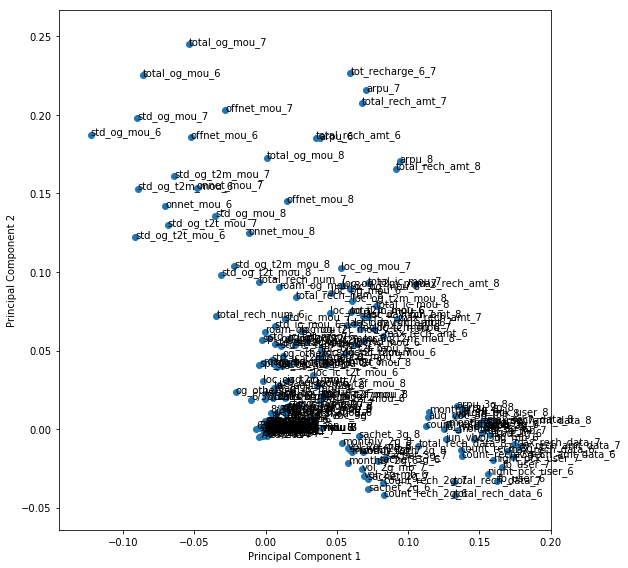

In [93]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
fig = plt.figure(figsize = (8,8))
plt.scatter(pcs_df.PC1, pcs_df.PC2)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
for i, txt in enumerate(pcs_df.Feature):
    plt.annotate(txt, (pcs_df.PC1[i],pcs_df.PC2[i]))
plt.tight_layout()
plt.show()

In [94]:
pca.explained_variance_ratio_

array([1.03726876e-01, 7.58451758e-02, 5.92236217e-02, 5.24887925e-02,
       4.14998271e-02, 3.96169838e-02, 3.50900954e-02, 3.28338006e-02,
       3.16816492e-02, 2.34136317e-02, 2.05894577e-02, 1.82268238e-02,
       1.70311649e-02, 1.63772506e-02, 1.59779804e-02, 1.54410973e-02,
       1.37592106e-02, 1.36347143e-02, 1.28375710e-02, 1.23155100e-02,
       1.18402215e-02, 1.16872425e-02, 1.09831234e-02, 1.08079240e-02,
       1.00518484e-02, 9.56859849e-03, 9.42958515e-03, 8.36913265e-03,
       7.92626202e-03, 7.82468708e-03, 7.49068906e-03, 6.92173766e-03,
       6.88510809e-03, 6.71454697e-03, 6.52484040e-03, 6.31636143e-03,
       6.09984021e-03, 5.90843005e-03, 5.77838102e-03, 5.70382881e-03,
       5.53648821e-03, 5.45612198e-03, 5.27117260e-03, 4.89624703e-03,
       4.82626337e-03, 4.63584107e-03, 4.43671838e-03, 4.28043165e-03,
       4.17507486e-03, 3.89834491e-03, 3.84708262e-03, 3.64362363e-03,
       3.54050041e-03, 3.45247712e-03, 3.40930905e-03, 3.17276082e-03,
      

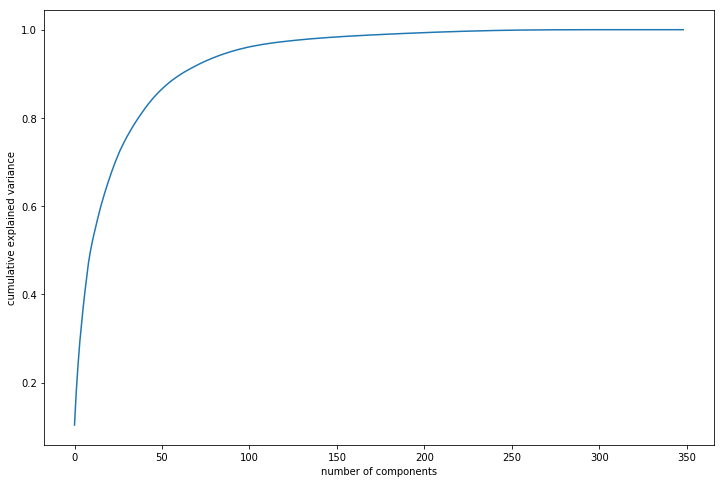

In [95]:
# Making the screeplot - plotting the cumulative variance against the number of components
%matplotlib inline
fig = plt.figure(figsize = (12,8))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.show()

## Let PCA select number of components based on a variance cutoff of 90 %

In [96]:
pca_again = PCA(0.90)

In [97]:
X_train.shape

(38204, 349)

In [98]:
df_train_pca2 = pca_again.fit_transform(X_train)
df_train_pca2.shape
# we see that PCA selected 63 components

(38204, 63)

In [99]:
df_train_pca2

array([[-0.0155211 ,  6.63150687, -2.67470656, ...,  0.53903242,
         0.71587298, -0.74388778],
       [-6.02719942,  5.5229846 , -5.94083625, ...,  1.31266533,
        -1.11898903,  1.61173196],
       [-2.05590157,  0.70142777,  1.29841949, ...,  0.29115007,
        -0.97950813,  0.6328226 ],
       ...,
       [ 0.3263973 ,  1.59831448,  3.36941885, ..., -0.32446741,
         0.57820052,  2.21127843],
       [ 5.30561603, -1.31609337,  1.76120134, ..., -0.14092609,
        -0.12375813, -0.38141839],
       [ 2.01075027, -1.07638369, -0.03954298, ..., -0.09447315,
         0.99316779,  0.60279803]])

## Number of components is 63 based on a variance cutoff of 90 %

In [100]:
# Create correlation matrix for the principal components
corrmat = np.corrcoef(df_train_pca2.transpose())

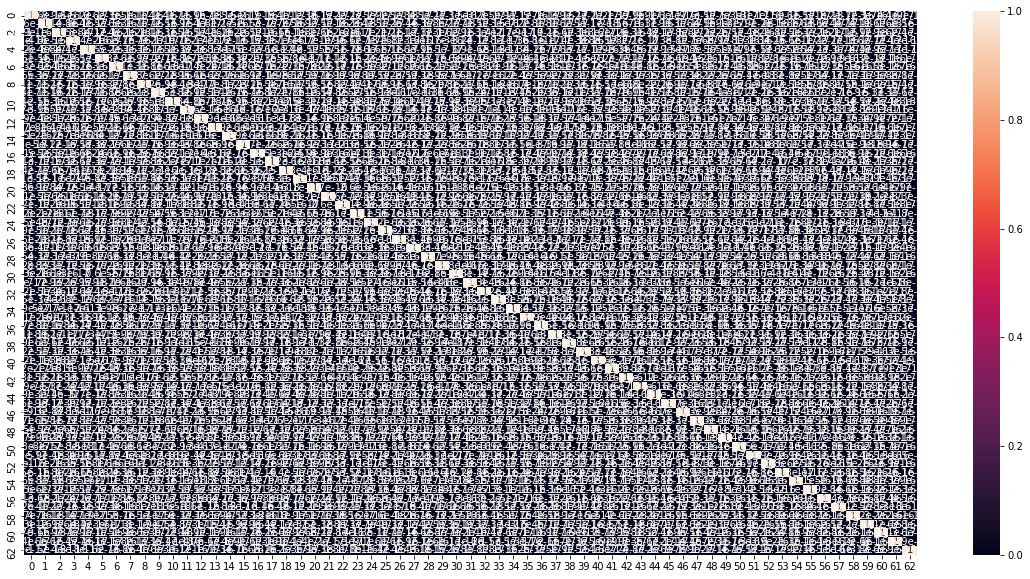

In [101]:
# Plot the correlation matrix
%matplotlib inline
plt.figure(figsize = (20,10))
sns.heatmap(corrmat,annot = True)

In [102]:
# 1s -> 0s in diagonals
corrmat_nodiag = corrmat - np.diagflat(corrmat.diagonal())
print("max corr:",corrmat_nodiag.max(), ", min corr: ", corrmat_nodiag.min(), )
# we see that correlations are indeed very close to 0

max corr: 1.3412752425439644e-15 , min corr:  -1.1039070619145466e-15


# (1) Build other Models - Start with Logistic Regression Model

In [103]:
#training the regression model
learner_pca2 = LogisticRegression()
model_pca2 = learner_pca2.fit(df_train_pca2, y_train)

In [104]:
df_test_pca2 = pca_again.transform(X_test)
df_test_pca2.shape

(16374, 63)

In [105]:
pd.DataFrame(df_test_pca2).info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16374 entries, 0 to 16373
Data columns (total 63 columns):
0     16374 non-null float64
1     16374 non-null float64
2     16374 non-null float64
3     16374 non-null float64
4     16374 non-null float64
5     16374 non-null float64
6     16374 non-null float64
7     16374 non-null float64
8     16374 non-null float64
9     16374 non-null float64
10    16374 non-null float64
11    16374 non-null float64
12    16374 non-null float64
13    16374 non-null float64
14    16374 non-null float64
15    16374 non-null float64
16    16374 non-null float64
17    16374 non-null float64
18    16374 non-null float64
19    16374 non-null float64
20    16374 non-null float64
21    16374 non-null float64
22    16374 non-null float64
23    16374 non-null float64
24    16374 non-null float64
25    16374 non-null float64
26    16374 non-null float64
27    16374 non-null float64
28    16374 non-null float64
29    16374 non-null float64
30    16374 non-null 

In [106]:
# Make predictions on the test data
pred_probs_test2 = model_pca2.predict_proba(df_test_pca2)[:,1]
"{:2.2f}".format(metrics.roc_auc_score(y_test, pred_probs_test2))

'0.89'

## Accuracy score is 89% on prediction

In [122]:
X_train_pca = pd.DataFrame(df_train_pca2)
X_test_pca = pd.DataFrame(df_test_pca2)
X_train_pca.head()

,0,1,2,3,4,5,6,7,8,9,...,53,54,55,56,57,58,59,60,61,62
0,-0.015521,6.631507,-2.674707,12.471367,0.255534,-8.340320,1.823297,-4.308280,-1.589054,-0.160770,...,-4.183477,1.081707,0.370383,-0.439928,1.954383,-1.072585,-0.354797,0.539032,0.715873,-0.743888
1,-6.027199,5.522985,-5.940836,-1.803208,-0.854044,3.796164,6.361657,3.243204,-10.052614,-1.893457,...,0.735897,-0.607212,-1.275881,0.021457,0.149233,0.047451,-2.237387,1.312665,-1.118989,1.611732
2,-2.055902,0.701428,1.298419,-1.008530,-0.108814,0.226719,0.849054,-3.236598,-0.193936,1.422808,...,0.015853,-0.134523,0.110103,0.012690,0.475338,0.295892,-0.256288,0.291150,-0.979508,0.632823
3,-2.877696,-1.291314,-0.711970,1.379138,-0.398343,-0.033369,1.452892,3.174014,-0.404696,-0.121976,...,-0.755623,-0.007284,0.027898,0.125950,-0.392111,-0.025465,-0.105274,-0.068295,-0.143700,0.352788
4,-0.955866,-2.595897,-0.710506,-1.246642,0.627733,-0.027386,0.692997,0.297197,-0.136379,-0.538748,...,-0.220561,-0.528130,-0.032093,0.101748,-0.056642,0.105123,0.065997,-0.030598,0.362376,-0.201126


# Building other Models - Random Forest Model

In [123]:
# Let's first fit a random forest model with default hyperparameters.
# Importing random forest classifier from sklearn library
from sklearn.ensemble import RandomForestClassifier
# Running the random forest with default parameters.
rfc = RandomForestClassifier()

In [124]:
# fit
rfc.fit(X_train_pca,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [125]:
# Making predictions
predictions = rfc.predict(X_test_pca)

In [126]:
# Importing classification report and confusion matrix from sklearn metrics
from sklearn.metrics import classification_report,confusion_matrix, accuracy_score

In [127]:
# Let's check the report of our default model
print(classification_report(y_test,predictions))

             precision    recall  f1-score   support

          0       1.00      0.97      0.99      8187
          1       0.97      1.00      0.99      8187

avg / total       0.99      0.99      0.99     16374



In [128]:
# Printing confusion matrix
print(confusion_matrix(y_test,predictions))

[[7954  233]
 [   0 8187]]


In [129]:
print(accuracy_score(y_test,predictions))

0.9857701233663124


# Tune Hyperparameters - Let's try to find the optimum values for max_depth 

In [130]:
# Now lets tune Hyperparameters
# GridSearchCV to find optimal n_estimators
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
# specify number of folds for k-fold CV
n_folds = 5

# parameters to build the model on
parameters = {'max_depth': range(2, 20, 5)}

# instantiate the model
rf = RandomForestClassifier()

# fit tree on training data
rf = GridSearchCV(rf, parameters, 
                    cv=n_folds, 
                   scoring="accuracy")

rf.fit(X_train_pca, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'max_depth': range(2, 20, 5)}, pre_dispatch='2*n_jobs',
       refit=True, return_train_score='warn', scoring='accuracy',
       verbose=0)

In [131]:
# scores of GridSearch CV
scores = rf.cv_results_
pd.DataFrame(scores).head()

C:\Users\purnendu.ghosh\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\purnendu.ghosh\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\purnendu.ghosh\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('split2_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,1.150599,0.189862,0.031162,0.011709,2,{'max_depth': 2},0.734755,0.721539,0.748429,0.759948,...,0.740865,0.012913,4,0.741902,0.712355,0.750523,0.761222,0.739694,0.741139,0.016264
1,3.775896,0.140347,0.042693,0.005580,7,{'max_depth': 7},0.848600,0.857891,0.851309,0.853534,...,0.852031,0.003441,3,0.863458,0.864799,0.859868,0.863630,0.865953,0.863542,0.002045
2,4.600540,0.905090,0.055883,0.028144,12,{'max_depth': 12},0.944125,0.946742,0.951832,0.944895,...,0.947440,0.002896,2,0.968032,0.965971,0.971273,0.963585,0.970096,0.967791,0.002775
3,3.854038,1.454810,0.041394,0.018498,17,{'max_depth': 17},0.970296,0.974614,0.973953,0.971335,...,0.971966,0.001979,1,0.991296,0.990707,0.990479,0.989465,0.990708,0.990531,0.000598


C:\Users\purnendu.ghosh\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


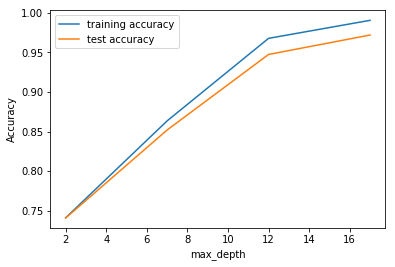

In [132]:
# plotting accuracies with max_depth
plt.figure()
plt.plot(scores["param_max_depth"], 
         scores["mean_train_score"], 
         label="training accuracy")
plt.plot(scores["param_max_depth"], 
         scores["mean_test_score"], 
         label="test accuracy")
plt.xlabel("max_depth")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

# Tuning max_features, which is the maximum numbre of features considered for splitting at a node.

In [133]:
# GridSearchCV to find optimal max_features
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV

# specify number of folds for k-fold CV
n_folds = 5

# parameters to build the model on
parameters = {'max_features': [4, 8, 14, 20, 24]}

# instantiate the model
rf = RandomForestClassifier(max_depth=4)


# fit tree on training data
rf = GridSearchCV(rf, parameters, 
                    cv=n_folds, 
                   scoring="accuracy")

rf.fit(X_train_pca, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=4, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'max_features': [4, 8, 14, 20, 24]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

In [134]:
# scores of GridSearch CV
scores = rf.cv_results_
pd.DataFrame(scores).head()

C:\Users\purnendu.ghosh\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\purnendu.ghosh\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\purnendu.ghosh\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('split2_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_features,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.599276,0.017717,0.013436,0.001832,4,{'max_features': 4},0.771133,0.794164,0.782461,0.800262,...,0.788818,0.010634,5,0.779236,0.788528,0.792337,0.800877,0.802775,0.792751,0.008569
1,1.172657,0.072210,0.015241,0.002406,8,{'max_features': 8},0.802146,0.802408,0.806545,0.799346,...,0.800989,0.003974,4,0.808880,0.798246,0.811870,0.803363,0.797998,0.804072,0.005573
2,1.817448,0.032127,0.013235,0.001169,14,{'max_features': 14},0.801492,0.804371,0.806806,0.808639,...,0.804523,0.002888,2,0.806001,0.803383,0.812590,0.807420,0.805686,0.807016,0.003073
3,4.642009,1.386352,0.022730,0.013112,20,{'max_features': 20},0.807380,0.818241,0.812827,0.807330,...,0.810727,0.004287,1,0.812545,0.814246,0.815142,0.810038,0.810725,0.812539,0.001961
4,7.203562,0.723078,0.036426,0.004727,24,{'max_features': 24},0.799267,0.806333,0.795026,0.801832,...,0.801958,0.004545,3,0.806001,0.804365,0.802120,0.805752,0.812557,0.806159,0.003483


C:\Users\purnendu.ghosh\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


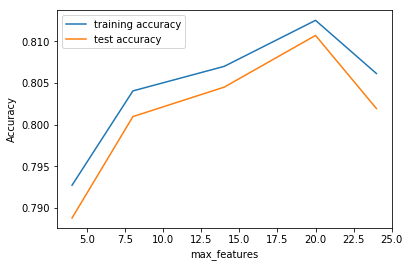

In [135]:
# plotting accuracies with max_features
plt.figure()
plt.plot(scores["param_max_features"], 
         scores["mean_train_score"], 
         label="training accuracy")
plt.plot(scores["param_max_features"], 
         scores["mean_test_score"], 
         label="test accuracy")
plt.xlabel("max_features")
plt.ylabel("Accuracy")
plt.legend()
plt.show()


# Grid Search to Find Optimal Hyperparameters

In [143]:
# Create the parameter grid based on the results of random search 
param_grid = {
    'max_depth': [4,8,10],
    'min_samples_leaf': range(100, 400, 200),
    'min_samples_split': range(200, 500, 200),
    'n_estimators': [100,200, 300], 
    'max_features': [5, 10]
}
# Create a based model
rf = RandomForestClassifier()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = 1,verbose = 1)

In [144]:
# Fit the grid search to the data
grid_search.fit(X_train_pca, y_train)

Fitting 3 folds for each of 72 candidates, totalling 216 fits


[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:  4.8min
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed: 30.4min
[Parallel(n_jobs=3)]: Done 216 out of 216 | elapsed: 35.6min finished


GridSearchCV(cv=3, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid=True, n_jobs=3,
       param_grid={'max_depth': [4, 8, 10], 'min_samples_leaf': range(100, 400, 200), 'min_samples_split': range(200, 500, 200), 'n_estimators': [100, 200, 300], 'max_features': [5, 10]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=1)

In [145]:
# printing the optimal accuracy score and hyperparameters
print('We can get accuracy of',grid_search.best_score_,'using',grid_search.best_params_)

We can get accuracy of 0.8526594073918962 using {'max_depth': 10, 'max_features': 10, 'min_samples_leaf': 100, 'min_samples_split': 200, 'n_estimators': 100}


In [146]:
#Fitting the final model with the best parameters obtained from grid search.
# model with the best hyperparameters
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(bootstrap=True,
                             max_depth=10,
                             min_samples_leaf=100, 
                             min_samples_split=200,
                             max_features=10,
                             n_estimators=100)

In [147]:
# fit
rfc.fit(X_train_pca,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=10, max_features=10, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=100, min_samples_split=200,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [148]:
# predict
predictions = rfc.predict(X_test_pca)

In [149]:
print(classification_report(y_test,predictions))

             precision    recall  f1-score   support

          0       0.85      0.87      0.86      8187
          1       0.87      0.85      0.86      8187

avg / total       0.86      0.86      0.86     16374



In [150]:
print(confusion_matrix(y_test,predictions))

[[7142 1045]
 [1240 6947]]


In [151]:
print(accuracy_score(y_test,predictions))

0.8604494930988152


## We see Random Forest Model overall AUC score of 0.86

# Building the other Models - SVM - Non Linear

In [152]:
# Model Building
from sklearn.svm import SVC
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
# using rbf kernel, C=1, default value of gamma
model = SVC(C = 1, kernel='rbf')
model.fit(X_train_pca, y_train)
y_pred = model.predict(X_test_pca)

In [153]:
# Model Evaluation
# confusion matrix
confusion_matrix(y_true=y_test, y_pred=y_pred)

array([[7424,  763],
       [ 577, 7610]], dtype=int64)

In [154]:
# accuracy
print("accuracy", metrics.accuracy_score(y_test, y_pred))

# precision
print("precision", metrics.precision_score(y_test, y_pred))

# recall/sensitivity
print("recall", metrics.recall_score(y_test, y_pred))

accuracy 0.9181629412483205
precision 0.9088737608981249
recall 0.9295224135825089


# Hyperparameter Tuning -The choice of kernel (linear, rbf etc.), C, gamma
We'll use the GridSearchCV() method to tune the hyperparameters

In [ ]:
# creating a KFold object with 5 splits 
folds = KFold(n_splits = 5, shuffle = True, random_state = 4)

# specify range of hyperparameters
# Set the parameters by cross-validation
hyper_params = [ {'gamma': [1e-2, 1e-3, 1e-4],
                     'C': [1, 10, 100, 1000]}]


# specify model
model = SVC(kernel="rbf")

# set up GridSearchCV()
model_cv = GridSearchCV(estimator = model, 
                        param_grid = hyper_params, 
                        scoring= 'accuracy', 
                        cv = folds, 
                        verbose = 1,
                        return_train_score=True)      

# fit the model
model_cv.fit(X_train_pca, y_train) 

In [ ]:
# cv results
cv_results = pd.DataFrame(model_cv.cv_results_)
cv_results

In [ ]:
# converting C to numeric type for plotting on x-axis
cv_results['param_C'] = cv_results['param_C'].astype('int')

# # plotting
plt.figure(figsize=(16,6))

# subplot 1/3
plt.subplot(131)
gamma_01 = cv_results[cv_results['param_gamma']==0.01]

plt.plot(gamma_01["param_C"], gamma_01["mean_test_score"])
plt.plot(gamma_01["param_C"], gamma_01["mean_train_score"])
plt.xlabel('C')
plt.ylabel('Accuracy')
plt.title("Gamma=0.01")
plt.ylim([0.80, 1])
plt.legend(['test accuracy', 'train accuracy'], loc='upper left')
plt.xscale('log')

# subplot 2/3
plt.subplot(132)
gamma_001 = cv_results[cv_results['param_gamma']==0.001]

plt.plot(gamma_001["param_C"], gamma_001["mean_test_score"])
plt.plot(gamma_001["param_C"], gamma_001["mean_train_score"])
plt.xlabel('C')
plt.ylabel('Accuracy')
plt.title("Gamma=0.001")
plt.ylim([0.80, 1])
plt.legend(['test accuracy', 'train accuracy'], loc='upper left')
plt.xscale('log')


# subplot 3/3
plt.subplot(133)
gamma_0001 = cv_results[cv_results['param_gamma']==0.0001]

plt.plot(gamma_0001["param_C"], gamma_0001["mean_test_score"])
plt.plot(gamma_0001["param_C"], gamma_0001["mean_train_score"])
plt.xlabel('C')
plt.ylabel('Accuracy')
plt.title("Gamma=0.0001")
plt.ylim([0.80, 1])
plt.legend(['test accuracy', 'train accuracy'], loc='upper left')
plt.xscale('log')


In [ ]:
# printing the optimal accuracy score and hyperparameters
best_score = model_cv.best_score_
best_hyperparams = model_cv.best_params_

print("The best test score is {0} corresponding to hyperparameters {1}".format(best_score, best_hyperparams))

# Building and Evaluating the Final Model
Build and evaluate the final model, i.e. the model with highest test accuracy.

In [ ]:
# specify optimal hyperparameters
best_params = {"C": 100, "gamma": 0.0001, "kernel":"rbf"}

# model
model = SVC(C=100, gamma=0.0001, kernel="rbf")

model.fit(X_train_pca, y_train)
y_pred = model.predict(X_test_pca)

# metrics
print(metrics.confusion_matrix(y_test, y_pred), "\n")
print("accuracy", metrics.accuracy_score(y_test, y_pred))
print("precision", metrics.precision_score(y_test, y_pred))
print("sensitivity/recall", metrics.recall_score(y_test, y_pred))

# Conclusion

In [ ]:
#*********Need to Add***************